In [1]:
#%matplotlib nbagg
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from matplotlib import animation

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

### Prepare data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_01.csv')

In [3]:
sc = StandardScaler()

In [4]:
train['ecg'] = sc.fit_transform(train[['ecg']])
test['ecg'] = sc.transform(test[['ecg']])

In [5]:
# load a model
with open('../model/knn_model.pickle', 'rb') as f:
    model = pickle.load(f)

In [6]:
# a function to create vectors with a window size using sliding window
def embed(data, window_size):
    vector_list = []
    for i in range(data.size - window_size + 1):
        tmp = data.tolist()[i:i+window_size]
        vector_list.append(tmp)

    return vector_list

In [7]:
# process data
test_vectors = embed(test['ecg'].values, 20)

In [8]:
# calculate anomaly
d_test = model.kneighbors(test_vectors)[0]
mx = pd.read_csv('../data/knn_distance_max.csv', header=None, names=['max'])
knn_anomaly = d_test.flatten() / mx['max'][0]

### Animation

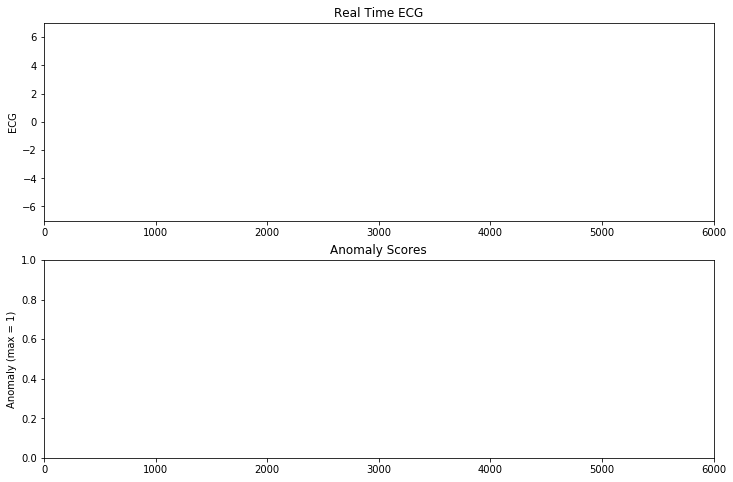

In [9]:
# create subpolts
fig, ax = plt.subplots(2, 1, figsize=(12, 8));

# data for update the graph
x_ax_0 = []
y_ax_0 = []
x_ax_1 = []
y_ax_1 = []

# line plot
line1, = ax[0].plot([], [])
line2, = ax[1].plot([], [])

# set property
ax[0].set_title('Real Time ECG')
ax[0].set_ylim(-7, 7)
ax[0].set_xlim(0, 6000)
ax[0].set_ylabel('ECG')

ax[1].set_title('Anomaly Scores');
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 6000)
ax[1].set_ylabel('Anomaly (max = 1)')

ax[1].hlines(0.18, 0, len(test['ecg']), "red", linestyles='dashed', alpha=0.5)

# update plot
def plot(i):
    
    #update the data
    x_ax_0.append([i])
    y_ax_0.append(test['ecg'].values[i])
    
    line1.set_data(x_ax_0, y_ax_0)
    
    x_ax_1.append([i])
    y_ax_1.append(knn_anomaly[i])
    line2.set_data(x_ax_1, y_ax_1)
    
    # change background color if the data is over a threshold
    if knn_anomaly[i] >= 0.18:
        ax[0].patch.set_facecolor(color='red')
        ax[0].patch.set_alpha(0.6)
    else:
        ax[0].patch.set_facecolor(color='white')
    
    return line1, line2

# start animation
ani = animation.FuncAnimation(fig, plot, frames=range(0, test.shape[0], 3), interval=1, blit=True, repeat=False)
#ani.save('demo.gif', writer='pillow', fps=30)